<a href="https://colab.research.google.com/github/ysw24neurorad/Acute-stroke_Detection_Segmentation/blob/main/UNETR_%2B_MONAI_brats_segmentation_3d_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UNETR on Brain tumor 3D segmentation

Goal: I will use an existing tutorial of the MONAI lib on brats that handles all the preprocessing and data loading to test a newly-proposed transformer based model from NVidia call [UNETR](https://paperswithcode.com/paper/unetr-transformers-for-3d-medical-image)

### Original Tutorial [link](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## License
 Copyright 2020 MONAI Consortium
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Workflow
This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. Load **UNETR model from our AI SUMMER self-attention-cv lib**
1. Use Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

## Dataset
The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](https://github.com/Project-MONAI/tutorials/blob/master/figures/brats_tasks.png?raw=1)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).



## Setup environment, imports

In [ ]:
!pip install monai tqdm
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install self-attention-cv==1.2.3
%matplotlib inline

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch

print_config()

     |████████████████████████████████| 650 kB 5.2 MB/s 
     |████████████████████████████████| 42 kB 608 kB/s 
     |████████████████████████████████| 280 kB 8.3 MB/s 
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: pytest
    Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
MONAI version: 0.7.0
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
root_dir = './'
print(root_dir)
set_determinism(seed=0)

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

./


## Setup transforms for training and validation

In [ ]:
roi_size=[128, 128, 64]
pixdim=(1.5, 1.5, 2.0)

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=pixdim,
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=roi_size, random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=pixdim,
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, so we set `cache_num=100` to cache 100 items for training and use the defaut args to cache all the items for validation.

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm]"
cache_num = 8

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    num_workers=4,
    cache_num=cache_num, # it was 100 but we use larger volumes
)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=cache_num,
)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)

     |████████████████████████████████| 699 kB 5.1 MB/s 


Task01_BrainTumour.tar: 7.09GB [03:43, 34.1MB/s]                            


Downloaded: ./Task01_BrainTumour.tar
Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
Writing into directory: ./.


Loading dataset: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


## Check data shape and visualize

image shape: torch.Size([4, 128, 128, 64])


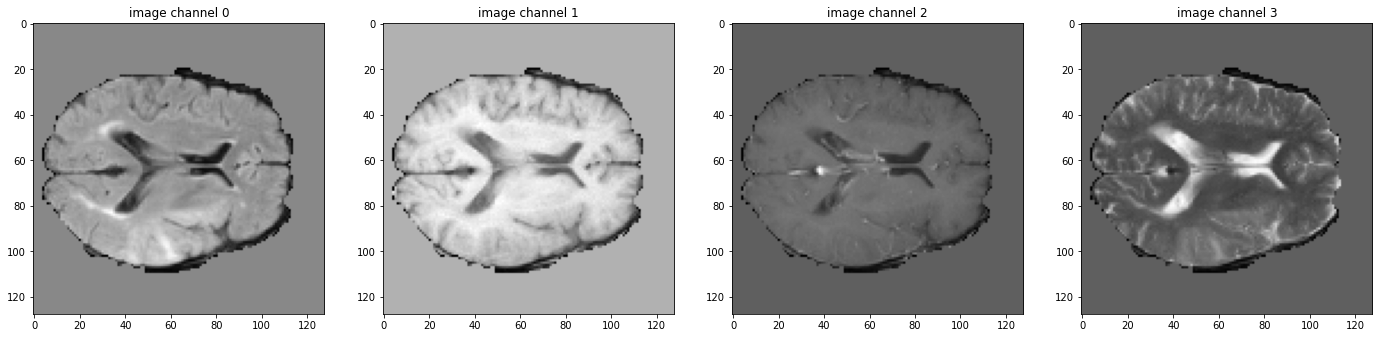

label shape: torch.Size([3, 128, 128, 64])


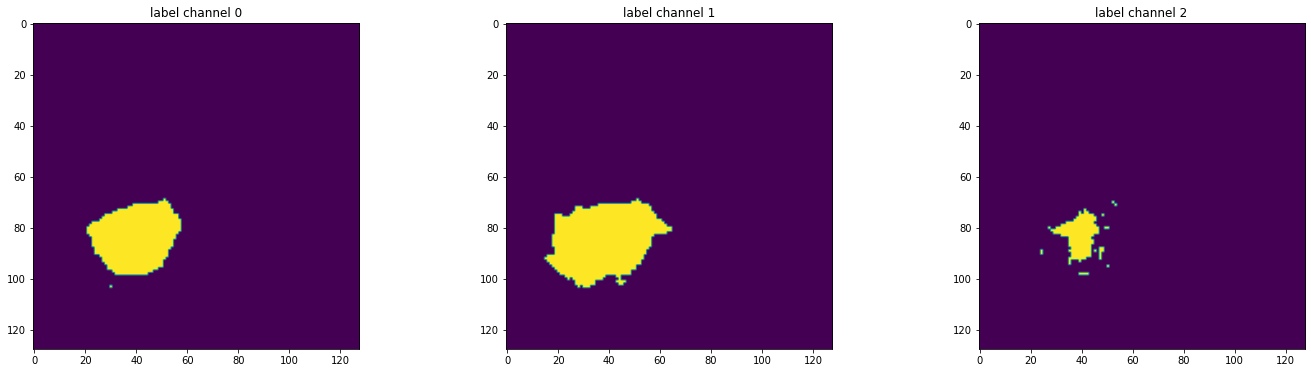

(128, 128, 64)


In [ ]:
slice_id = 32
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_ds[2]['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_ds[2]["image"][i, :, :, slice_id].detach().cpu(),  cmap="gray") #
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[2]['label'].shape}")
plt.figure("label", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_ds[6]["label"][i, :, :, slice_id].detach().cpu())
plt.show()

train_size = tuple(val_ds[6]['image'].shape[1:])
print(train_size)

## Proposed transormer based model

In [ ]:
#from monai.networks.nets import UNETR as UNETR_monai

from self_attention_cv import UNETR
device = torch.device("cuda:0")
num_heads = 10 # 12 normally
embed_dim= 512 # 768 normally


# model = UNETR(img_shape=tuple(roi_size), input_dim=4, output_dim=3,
#                  embed_dim=embed_dim, patch_size=16, num_heads=num_heads,
#                ext_layers=[3, 6, 9, 12], norm='instance',
#                  base_filters=16,
#                  dim_linear_block=2048).to(device)

model = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# model = UNETR_monai(
#     in_channels=4,
#     out_channels=3,
#     img_size=tuple(roi_size),
#     feature_size=16,
#     hidden_size=embed_dim,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
# ).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())/1000000
print('Parameters in millions:',pytorch_total_params)

Parameters in millions: 4.810074


## Create Model, Loss, Optimizer, Execute a typical PyTorch training process

In [ ]:
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss

loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

max_epochs = 180
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

torch.cuda.empty_cache()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)

                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.mean().item()
                metric_count += not_nans
                metric_sum += value.mean().item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

save_name = "./last.pth"
torch.save(model.state_dict(),save_name)
from google.colab import files
files.download(save_name)

print(
    f"train completed, best_metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)


----------
epoch 1/180
epoch 1 average loss: 1.7725
----------
epoch 2/180
epoch 2 average loss: 1.3845
----------
epoch 3/180
epoch 3 average loss: 1.1432
----------
epoch 4/180
epoch 4 average loss: 1.0639
----------
epoch 5/180
epoch 5 average loss: 1.0266
saved new best metric model
current epoch: 5 current mean dice: 0.2476 tc: 0.0224 wt: 0.7207 et: 0.0000
best mean dice: 0.2476 at epoch: 5
----------
epoch 6/180
epoch 6 average loss: 1.0014
----------
epoch 7/180
epoch 7 average loss: 0.9804
----------
epoch 8/180
epoch 8 average loss: 0.9594
----------
epoch 9/180
epoch 9 average loss: 0.9356
----------
epoch 10/180
epoch 10 average loss: 0.9040
saved new best metric model
current epoch: 10 current mean dice: 0.3193 tc: 0.0204 wt: 0.8398 et: 0.0660
best mean dice: 0.3193 at epoch: 10
----------
epoch 11/180
epoch 11 average loss: 0.8684
----------
epoch 12/180
epoch 12 average loss: 0.8326
----------
epoch 13/180
epoch 13 average loss: 0.8044
----------
epoch 14/180
epoch 14 ave

In [ ]:

# unet tutorial result: train completed, best_metric: 0.7537  at epoch: 160 # official tutorial
# train completed, best_metric: 0.7660 at epoch: 170 # my run

# self-attention-cv implementation of unetr
# current epoch: 180 current mean dice: 0.7686 tc: 0.8116 wt: 0.8935 et: 0.6065
# best mean dice: 0.7686 at epoch: 180

# reduced version 50m params
current epoch: 180 current mean dice: 0.7693 tc: 0.8161 wt: 0.8922 et: 0.6057
best mean dice: 0.7693 at epoch: 180

# unetr monai implementation
# current epoch: 175 current mean dice: 0.7612 tc: 0.8122 wt: 0.8790 et: 0.5982

## Plot the loss and metric

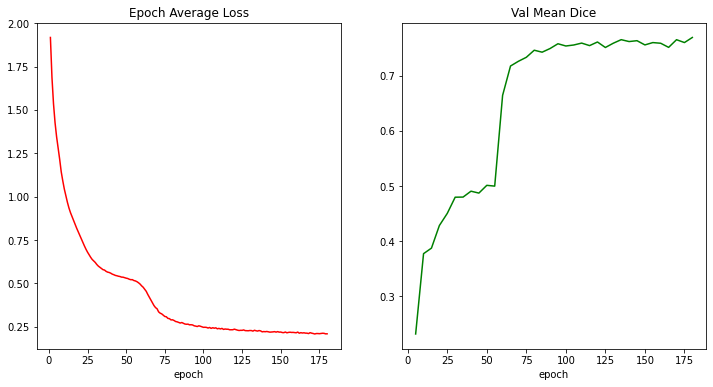

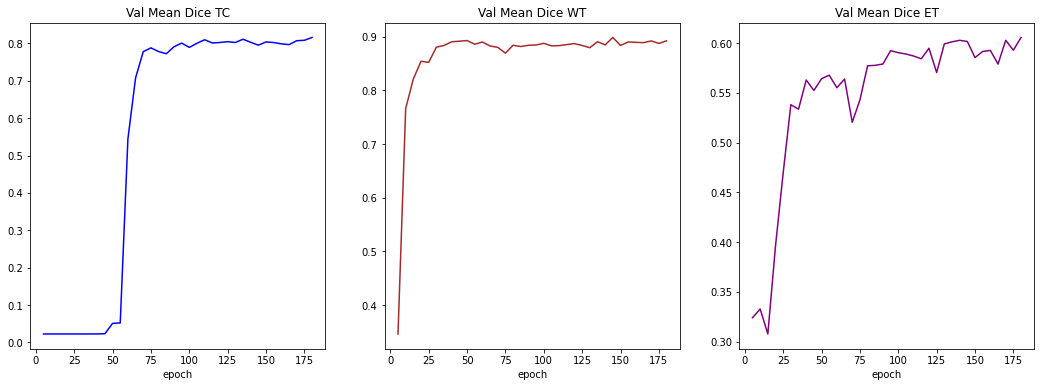

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

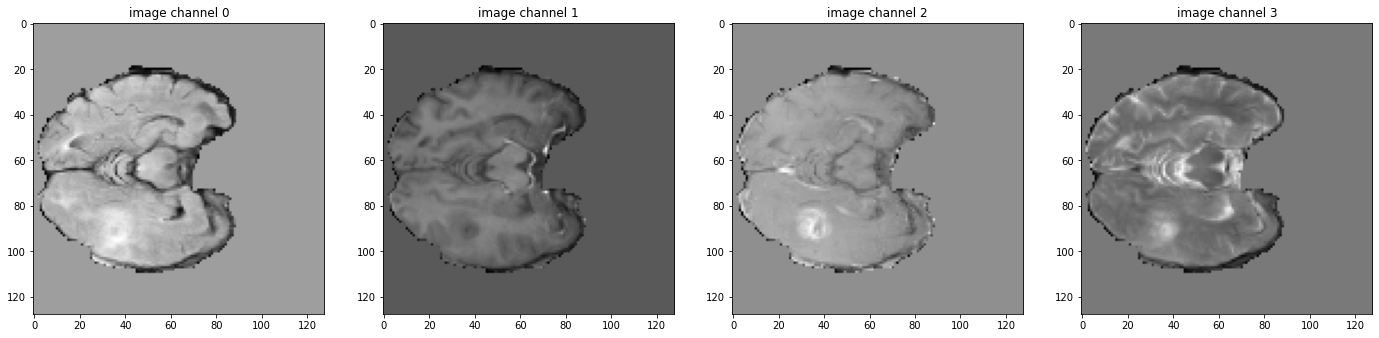

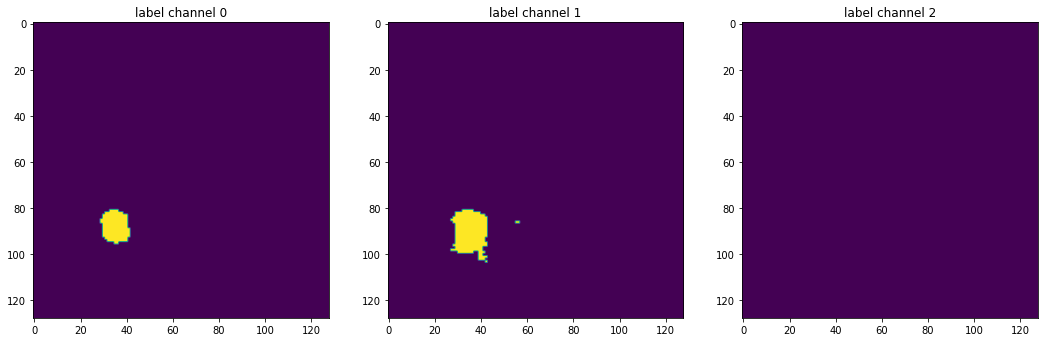

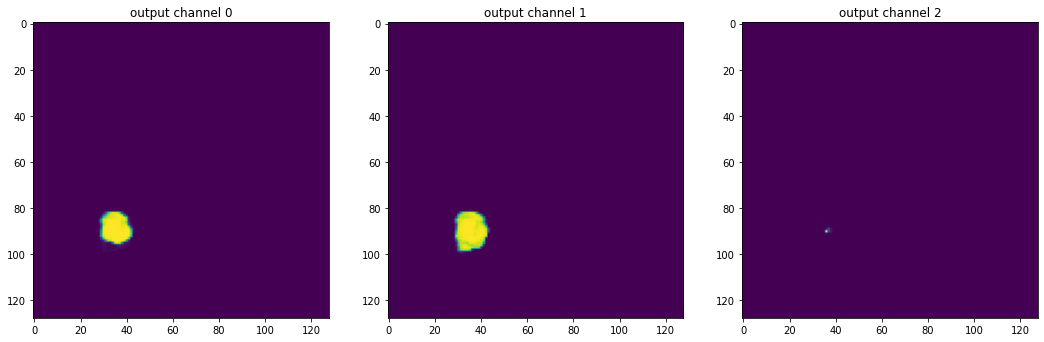

In [ ]:

model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    val_output = model(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 20].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 20].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        out_tensor = torch.sigmoid(val_output[0, i, :, :, 20]).detach().cpu()
        plt.imshow(out_tensor)
    plt.show()